In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.distributions import Normal
from torch.distributions import StudentT
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import math
from scipy.stats import norm
from collections import defaultdict
from random import uniform
from tqdm import tqdm
import scipy.stats
from scipy.integrate import quad
from torch.optim.optimizer import Optimizer, required
from __future__ import annotations
import pytest

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
print(f"device: {device}")

device: cpu


In [3]:
def gaussian_kernel(kernel_size=5, sigma=1.0):
        x = torch.arange(kernel_size, device=device) - kernel_size // 2
        kernel = torch.exp(-0.5 * (x / sigma)**2)
        kernel = kernel / kernel.sum()  # normalize
        return kernel.view(1, 1, -1)    # [out_channels, in_channels, width]

In [4]:
class ArbitraryMomentumSGD(Optimizer):
    def __init__(self, params, lr=required, momentum_schedule=None, weight_decay=0.0):
        """
        Custom SGD that accepts arbitrary momentum (can be negative or >1),
        with optional weight decay (L2 regularization).
        
        Arguments:
        - params: model parameters
        - lr: learning rate
        - momentum_schedule: callable or float.
            If callable: should return momentum given current step.
            If float: fixed momentum value.
        - weight_decay: L2 penalty (default: 0.0)
        """
        defaults = dict(lr=lr, momentum_schedule=momentum_schedule, step=0, weight_decay=weight_decay)
        super(ArbitraryMomentumSGD, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step."""

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            step = group['step']
            momentum_schedule = group['momentum_schedule']
            weight_decay = group['weight_decay']

            # Evaluate momentum
            if callable(momentum_schedule):
                momentum = momentum_schedule(step)
            else:
                momentum = momentum_schedule

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                # Apply weight decay
                if weight_decay != 0.0:
                    d_p = d_p.add(p.data, alpha=weight_decay)

                # Initialize velocity if not present
                state = self.state[p]
                if 'velocity' not in state:
                    state['velocity'] = torch.zeros_like(p.data)

                v = state['velocity']
                v.mul_(momentum).add_(d_p, alpha=-lr)
                p.data.add_(v)

            # Increment step counter
            group['step'] += 1

        return loss

In [5]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.fc2(self.dropout(F.relu(self.fc1(x))))

In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, asset_size, value_size, seq_len, lstm_layers, num_heads=16, dropout=0.0):
        super().__init__()
        
        self.A = asset_size
        self.V = value_size
        self.T = seq_len
        self.d_model = d_model

        self.pre_ffn = PositionwiseFeedForward(d_model, d_model*4, dropout)
        self.pre_ffn_norm = nn.LayerNorm(d_model)
        
        self.asset_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.asset_attn_norm = nn.LayerNorm(d_model)
        
        self.ffn = PositionwiseFeedForward(d_model, d_model*4, dropout)
        self.ffn_norm = nn.LayerNorm(d_model)

        # lstm
        self.lstm = nn.LSTM(
            input_size=d_model,
            hidden_size=d_model,   # or 2*d_model
            num_layers=lstm_layers,
            batch_first=True,
        )
        self.lstm_norm = nn.LayerNorm(d_model)

        self.mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
        self.temp_attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.temp_attn_norm = nn.LayerNorm(d_model)

        self.lstm_ffn = PositionwiseFeedForward(d_model, d_model*4, dropout)
        self.lstm_ffn_norm = nn.LayerNorm(d_model)

    def forward(self, x):  # [B, A*V*T, d_model]
        B = x.shape[0]
        A = self.A
        V = self.V
        T = self.T
        
        # Pre FFN
        pre_ffn = self.pre_ffn(x) # [B, A*V*T, d_model]
        pre_ffn_norm = self.pre_ffn_norm(x + pre_ffn) # [B, A*V*T, d_model]

        # === Self Attention ===
        asset = pre_ffn_norm.reshape(B*T, A*V, self.d_model) # [B*T, A*V, d_model]
        asset_attn, _ = self.asset_attn(asset, asset, asset) # [B*T, A*V, d_model]
        asset_attn_norm = self.asset_attn_norm(asset_attn + asset) # [B*T, A*V, d_model]

        # FFN
        ffn_reshaped = asset_attn_norm.reshape(B, T, A*V, self.d_model) # [B, T, A*V, d_model]
        ffn = self.ffn(ffn_reshaped) # [B, T, A*V, d_model]
        ffn_norm = self.ffn_norm(ffn + ffn_reshaped) # [B, T, A*V, d_model]

        # LSTM
        pre_lstm = ffn_norm.transpose(1, 2) # [B, A*V, T, d_model]
        reshape_lstm = pre_lstm.reshape(B*A*V, T, self.d_model)
        lstm, (h, c) = self.lstm(reshape_lstm) # [B*A*V, T, d_model]
        lstm_norm = self.lstm_norm(reshape_lstm + lstm) # [B*A*V, T, d_model]

        # LSTM FFN
        lstm_ffn = self.lstm_ffn(lstm_norm) # [B*A*V, T, d_model]
        lstm_ffn_norm = self.lstm_ffn_norm(lstm_ffn + lstm_norm) # [B*A*V, T, d_model]

        # Temporal attention
        temp_attn, _ = self.temp_attn(lstm_ffn_norm, lstm_ffn_norm, lstm_ffn_norm, attn_mask=self.mask) # [B*A*V, T, d_model]
        temp_attn_norm = self.temp_attn_norm(temp_attn + lstm_ffn_norm) # [B*A*V, T, d_model]

        reshape_final = temp_attn_norm.reshape(B, A*V*T, self.d_model) # [B, A*V*T, d_model]
        
        return reshape_final # [B, A*V*T, d_model]

In [7]:
def sinusoidal_embedding(n: int, d_model: int) -> torch.Tensor:
    """
    Create sinusoidal positional encodings (like in Transformers).
    Args:
        n: number of positions (e.g., assets, values, or timesteps)
        d_model: embedding dimension
    Returns:
        Tensor [n, d_model]
    """
    position = torch.arange(n, device=device).unsqueeze(1)              # [n, 1]
    div_term = torch.exp(torch.arange(0, d_model, 2, device=device) *
                         -(math.log(10000.0) / d_model))                # [d_model/2]

    pe = torch.zeros(n, d_model, device=device)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe


class HybridEmbedding(nn.Module):
    def __init__(self, num_assets: int, num_values: int, d_model: int):
        super().__init__()
        self.num_assets = num_assets
        self.num_values = num_values
        self.d_model = d_model

        # Deterministic base encodings
        self.register_buffer("asset_base", sinusoidal_embedding(num_assets, d_model))
        self.register_buffer("value_base", sinusoidal_embedding(num_values, d_model))

        # Learnable offsets (small adjustment per category)
        self.asset_offset = nn.Embedding(num_assets, d_model)#.weight.data.normal_(0, 0.1)
        self.value_offset = nn.Embedding(num_values, d_model)#.weight.data.normal_(0, 0.1)

    def forward(self, B: int, T: int):
        """
        Build [B, A, V, T, d_model] hybrid embeddings.
        Args:
            B: batch size
            T: number of timesteps
        """
        A, V, d_model = self.num_assets, self.num_values, self.d_model

        alpha = 0.1
        # Asset embeddings
        asset_ids = torch.arange(A, device=device)
        asset_embed = self.asset_base[asset_ids] + alpha * self.asset_offset(asset_ids)   # [A, d_model]
        asset_embed = asset_embed.view(1, A, 1, 1, d_model).expand(B, A, V, T, d_model)

        # Value embeddings
        value_ids = torch.arange(V, device=device)
        value_embed = self.value_base[value_ids] + alpha * self.value_offset(value_ids)   # [V, d_model]
        value_embed = value_embed.view(1, 1, V, 1, d_model).expand(B, A, V, T, d_model)

        return asset_embed + value_embed   # [B, A, V, T, d_model]

In [8]:
class Transformer(nn.Module):
    def __init__(self, d_model, asset_size, value_size, seq_len, bin_centers,
                 num_heads=16, lstm_leayers=1, num_transformer_blocks=1, dropout=0.0, kernel_size=5, sigma=1.0):

        super().__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma
        
        self.A = asset_size
        self.V = value_size
        self.T = seq_len
        self.bin_centers = bin_centers
        self.bin = bin_centers.shape[0]
        self.d_model = d_model

        # norm
        self.x_norm = nn.LayerNorm(d_model)
        self.time_norm = nn.LayerNorm(d_model)
        self.asset_norm = nn.LayerNorm(d_model)
        self.value_norm = nn.LayerNorm(d_model)
        
        self.time_norm2 = nn.LayerNorm(d_model)
        self.value_norm2 = nn.LayerNorm(d_model)
        
        # FFN
        self.value_ffn = PositionwiseFeedForward(d_model, int(d_model*2), dropout)
        self.time_ffn = PositionwiseFeedForward(d_model, int(d_model*2), dropout)

        # Learnable ID embeddings
        self.asset_embed = nn.Embedding(self.A, d_model)
        self.value_embed = nn.Embedding(self.V, d_model)

        # Sinusoidal time encoding
        self.register_buffer("time_pe", self._build_sinusoidal_pe(self.T, d_model))

        # Projection from raw value to d_model
        self.value_proj = nn.Linear(1, d_model)

        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, asset_size, value_size, seq_len, lstm_layers, num_heads, dropout) 
            for _ in range(num_transformer_blocks)
        ])

        # Output layer
        self.time_concat = nn.Linear(seq_len, 1)
        self.value_concat = nn.Linear(asset_size * value_size, asset_size)
        self.decoder = nn.Linear(d_model, bin_count)

    def _build_sinusoidal_pe(self, length, dim):
        position = torch.arange(length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * -(torch.log(torch.tensor(10000.0)) / dim))
        pe = torch.zeros(length, dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe  # shape: [T, d_model]

    def forward(self, x):
        # x: [B, A, V, T]
        B, A, V, T = x.shape
        device = x.device

        # === OHLCV input embedding ===
        x = x.unsqueeze(-1)  # [B, A, V, T, 1]
        x_proj = self.value_proj(x)  # [B, A, V, T, d_model]
        x_norm = self.x_norm(x_proj)

        # Time embeddings
        time_embed = self.time_pe[:T].to(device)  # [T, d_model]
        time_embed = time_embed.view(1, 1, 1, T, self.d_model)
        time_embed = time_embed.repeat(B, A, V, 1, 1) # [B, A, V, T, d_model]
        time_norm = self.time_norm(time_embed)

        # Asset Value embeddings
        hybrid = HybridEmbedding(A, V, self.d_model)
        asset_value_embed = hybrid(B, T) # [B, A, V, T, d_model]
        asset_value_norm = self.asset_norm(asset_value_embed)

        # Final Embedding
        x_norm = x_norm + time_norm + asset_value_norm # [B, A, V, T, d_model]
        x_norm = x_norm.reshape(B, A * V * T, self.d_model)  # [B, A*V*T, d_model]

        # Transformer LSTM blocks
        for layer in self.transformer_blocks:
            x_norm = layer(x_norm) # [B, A*V*T, d_model]
        post_transformer = x_norm.reshape(B, T, A*V, self.d_model) # [B, T, A*V, d_model]

        # Collapse values
        value_concat = post_transformer.transpose(2, 3) # [B, T, d_model, A*V]
        value_concat = self.value_concat(value_concat) # [B, T, d_model, A]
        value_concat = value_concat.transpose(2, 3) # [B, T, A, d_model]

        # Value FFN
        value_ffn = self.value_ffn(value_concat) # [B, T, A, d_model]
        value_norm = self.value_norm2(value_concat + value_ffn) # [B, T, A, d_model]
        
        # Collapse time
        time_concat = value_norm.transpose(1, 3) # [B, d_model, A, T]
        time_concat = self.time_concat(time_concat).squeeze(-1) # [B, d_model, A]
        time_concat = time_concat.transpose(1, 2)

        # Time FFN
        time_ffn = self.time_ffn(time_concat) # [B, A, d_model]
        time_norm = self.time_norm2(time_concat + time_ffn) # [B, A, d_model]
        
        # Output
        output = self.decoder(time_norm) # [B, A, bins]

        # smooth labels
        kernel = gaussian_kernel(kernel_size=kernel_size, sigma=sigma)

        output = F.relu(output)
    
        # Reshape to [B*A, 1, bins] for conv1d
        pdf_reshaped = output.view(B * A, 1, self.bin)
        
        # Convolution (kernel should be [1,1,K])
        smoothed = F.conv1d(pdf_reshaped, kernel, padding="same")
        
        # Reshape back
        smoothed = smoothed.view(B, A, self.bin)
        smoothed_norm = smoothed / (smoothed.sum(dim=-1, keepdim=True))

        return smoothed_norm

In [9]:
def triangular_soft_label(co, lo, hi, bin_centers, kernel_size, sigma):
    """
    Create asymmetric triangular distributions based on observed return range.

    Args:
        co: [B, A] mode (peak, usually close/open return)
        lo: [B, A] lower bound (low/open return)
        hi: [B, A] upper bound (high/open return)
        bin_centers: [bins] tensor of return bin centers

    Returns:
        [B, A, bins]: Triangular soft label distribution
    """
    B, A = co.shape
    bins = bin_centers.shape[0]

    # Ensure valid ranges
    lo = torch.min(co, lo)
    hi = torch.max(co, hi)

    # Expand dimensions for broadcasting
    bin_centers = bin_centers.view(1, 1, bins)  # [1,1,bins]
    co = co.unsqueeze(-1)  # [B,A,1]
    lo = lo.unsqueeze(-1)
    hi = hi.unsqueeze(-1)

    # Piecewise linear triangular PDF
    left_mask = (bin_centers >= lo) & (bin_centers <= co)
    right_mask = (bin_centers > co) & (bin_centers <= hi)

    left_vals = (bin_centers - lo) / (co - lo + 1e-8)
    right_vals = (hi - bin_centers) / (hi - co + 1e-8)

    pdf = torch.where(left_mask, left_vals, torch.zeros_like(left_vals))
    pdf = torch.where(right_mask, right_vals, pdf)

    kernel = gaussian_kernel(kernel_size=kernel_size, sigma=sigma)
    
    # Reshape to [B*A, 1, bins] for conv1d
    pdf_reshaped = pdf.view(B * A, 1, bins)
    
    # Convolution (kernel should be [1,1,K])
    smoothed = F.conv1d(pdf_reshaped, kernel, padding="same")
    
    # Reshape back
    smoothed = smoothed.view(B, A, bins)
    smoothed = smoothed / (smoothed.sum(dim=-1, keepdim=True) + 1e-8)
    
    #smoothed_pdf = softplus_softmax(smoothed / temp, dim=-1)

    return smoothed  # [B, A, bins]

In [10]:
def wasserstein_loss(pred_probs, target_probs):
    """
    Args:
        pred_probs: [B, A, bins] tensor from softmax
        target_probs: [B, A, bins] tensor from triangular_soft_label

    Returns:
        Scalar loss: mean Wasserstein distance across [B, A]
    """
    cdf_pred = torch.cumsum(pred_probs, dim=-1)     # [B, A, bins]
    cdf_target = torch.cumsum(target_probs, dim=-1) # [B, A, bins]
    w1 = torch.abs(cdf_pred - cdf_target).sum(dim=-1)  # [B, A]
    return w1.mean()

In [11]:
class StockDataset():
    def __init__(self, root_dir, seq_len=1024, num_days=1):
        self.seq_len = seq_len
        self.num_days = num_days
        self.root_dir = root_dir
        self.files = self.get_filenames()
        self.data = self.load_data()

    def get_filenames(self):
        files = os.listdir(self.root_dir)
        return files
    
    def load_data(self):
        # Array of dimension [stock name, price category(open, close, high, low, close, volume, date), sequence length]
        data = torch.zeros((len(self.files), 15, self.seq_len // self.num_days))
        
        for i, filename in enumerate(self.files):
            
            with open(self.root_dir + '/' + filename, 'r', encoding="utf-8") as file:
                #print(filename)
                #head = file.read(1000)
                #print(head)  # if this looks binary, it's not a JSON file!
                file.seek(0)
                content = json.load(file)
                time_series = content["Time Series (Daily)"]

                df = pd.DataFrame.from_dict(time_series, orient='index')
                df.columns = ['open', 'high', 'low', 'close', 'volume']
                df.index = pd.to_datetime(df.index)
                df = df.apply(pd.to_numeric, errors='coerce')

                o = torch.tensor(df["open"].values, dtype=torch.float32, device=device)
                c = torch.tensor(df["close"].values, dtype=torch.float32, device=device)
                h = torch.tensor(df["high"].values, dtype=torch.float32, device=device)
                l = torch.tensor(df["low"].values, dtype=torch.float32, device=device)
                v = torch.tensor(df["volume"].values, dtype=torch.float32, device=device)

                # All data is aranged from oldest to newest date
                # So we first have to flip the data by [::-1]
                # Percentage change r
                
                # O[t + 1] / O[t]
                data[i, 0, :] = (o.flatten()[:self.seq_len].flip(0)[::self.num_days] /
                                 o.flatten()[self.num_days:self.seq_len + self.num_days].flip(0)[::self.num_days]) -1
                # C[t + 1] / C[t]
                data[i, 1, :] = (c.flatten()[:self.seq_len].flip(0)[::self.num_days] /
                                 c.flatten()[self.num_days:self.seq_len + self.num_days].flip(0)[::self.num_days]) -1
                # H[t + 1] / H[t]
                data[i, 2, :] = (h.flatten()[:self.seq_len].flip(0)[::self.num_days] /
                                 h.flatten()[self.num_days:self.seq_len + self.num_days].flip(0)[::self.num_days]) -1
                # L[t + 1] / L[t]
                data[i, 3, :] = (l.flatten()[:self.seq_len].flip(0)[::self.num_days] /
                                 l.flatten()[self.num_days:self.seq_len + self.num_days].flip(0)[::self.num_days]) -1
                # O[t + 1] / C[t]
                data[i, 4, :] = (o.flatten()[:self.seq_len].flip(0)[::self.num_days] /
                                 c.flatten()[self.num_days:self.seq_len + self.num_days].flip(0)[::self.num_days]) -1
                # H[t + 1] / C[t]
                data[i, 5, :] = (h.flatten()[:self.seq_len].flip(0)[::self.num_days] /
                                 c.flatten()[self.num_days:self.seq_len + self.num_days].flip(0)[::self.num_days]) -1
                # L[t + 1] / C[t]
                data[i, 6, :] = (l.flatten()[:self.seq_len].flip(0)[::self.num_days] /
                                 c.flatten()[self.num_days:self.seq_len + self.num_days].flip(0)[::self.num_days]) -1
                # C[t + 1] / O[t + 1]
                data[i, 7, :] = (c.flatten()[:self.seq_len].flip(0)[::self.num_days] /
                                 o.flatten()[self.num_days -1:self.seq_len + self.num_days -1].flip(0)[::self.num_days]) -1
                # H[t + 1] / O[t + 1]
                data[i, 8, :] = (h.flatten()[:self.seq_len].flip(0)[::self.num_days] /
                                 o.flatten()[self.num_days -1:self.seq_len + self.num_days -1].flip(0)[::self.num_days]) -1
                # L[t + 1] / O[t + 1]
                data[i, 9, :] = (l.flatten()[:self.seq_len].flip(0)[::self.num_days] /
                                 o.flatten()[self.num_days -1:self.seq_len + self.num_days -1].flip(0)[::self.num_days]) -1
                # log(1 + V)
                data[i, 10, :] = np.log(1 + v.flatten()[:self.seq_len].flip(0)[::self.num_days])

                # convert date to unix time
                # dates = t.flatten()[:self.seq_len][::-1][::self.num_days]
                # data[i, 12, :] = dates.astype('datetime64[s]')
                # data[i, 12, :] = data[i, 7, :].astype('int64')

                file.close()

            ### Extra statistics
            ## high - low
            data[:, 11, :] = data[:, 2, :] - data[:, 3, :] # daily range high - low

            # Fill performance metrics arrays
            max_length = seq_len * 2
            min_length = 5
            for t in range(self.seq_len // self.num_days):
                length = t
                
                if length > max_length:
                    length = max_length

                # Compute performance only if more than 10 samples are available
                if t < min_length:
                    sharpe_ratio, max_drawdown, annualized_return, equity_curve = calc_performance_metrics(
                        data[:, 4, t : t+5]*0) # [A]
                else:
                    sharpe_ratio, max_drawdown, annualized_return, equity_curve = calc_performance_metrics(
                        data[:, 4, t-length : t+1]) # [A]

                data[:, 12, t] = sharpe_ratio
                data[:, 13, t] = max_drawdown
                data[:, 14, t] = annualized_return

        return data

    def average(self, decay_fac=0.0):
        
        avg_arr = torch.zeros_like(self.data)
        
        for i in range(self.seq_len):
            exp_decay = torch.exp(-decay_fac * torch.arange(0, self.seq_len - i))
            exp_decay = exp_decay[::-1]
            exp_decay = torch.expand_dims(exp_decay, dim=0)
            exp_decay = torch.expand_dims(exp_decay, dim=0)
            exp_decay = torch.repeat(exp_decay, repeats=len(self.files), axis=0)
            exp_decay = torch.repeat(exp_decay, repeats=5, axis=1)
            avg_arr[:,:-1,i] = np.sum(self.data[:,:-1,i:] * exp_decay, axis=-1) / np.sum(exp_decay[:,:,:], axis=-1)
        
        avg_arr[:,-1,:] = self.data[:,-1,:].copy()

        return avg_arr

    def recons_absol(self):
        # this function only provides a test to reconstruct the original shape of the stock prices
        abs_data = torch.zeros_like(self.data)
        abs_data[:,:,0] = 1.
        abs_data[:,-1,:] = self.data[:,-1,:]
        
        # iterate over all timesteps after the first
        for j in range(self.data.shape[2] - 1):
            abs_data[:, :-1, j+1] = abs_data[:, :-1, j] * (1 + self.data[:, :-1, j])

        return abs_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [12]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, max_deviation=100.):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_len = seq_len
        self.max_deviation = max_deviation

    def __len__(self):
        return self.data.shape[-1] -self.seq_len

    def __getitem__(self, idx):
        x = self.data[:, :, idx : idx + self.seq_len]
        y = self.data[:, 7:10, idx + self.seq_len]
        
        return x, y

In [13]:
def split_time_series(data, train_ratio=0.5, val_ratio=0.25):
    time_steps = data.shape[-1]
    #print(f"Time steps: {time_steps}")
    train_end = int(time_steps * train_ratio)
    val_end = int(time_steps * (train_ratio + val_ratio))
    return data[:, :, 0:train_end], data[:, :, train_end:val_end], data[:, :, val_end:]

In [14]:
def get_warmup_cosine_scheduler(optimizer, warmup_steps, plateau_steps, total_steps, lr_max):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return current_step / warmup_steps
        elif (current_step >= warmup_steps) & (current_step <  warmup_steps + plateau_steps):
            return 1.0
        else:
            progress = (current_step - warmup_steps - plateau_steps) / (total_steps - warmup_steps - plateau_steps)
            return 0.5 * (1 + math.cos(math.pi * progress))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

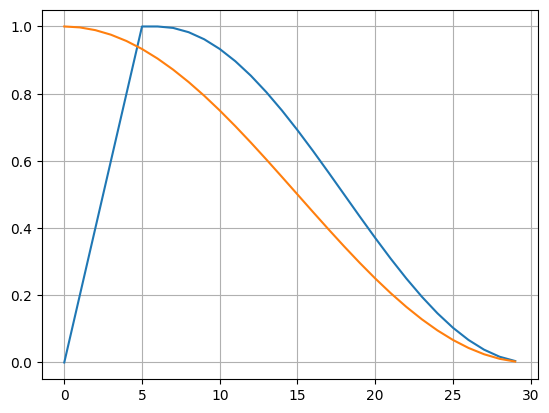

In [15]:
def cyclic_momentum(step):
    return 0.5 + 0.5 * np.cos(2 * np.pi * step / 60)

dummy_warmup_steps = 5
dummy_plateau_steps = 1
dummy_total_steps = 30
dummy_lr = np.zeros(dummy_total_steps)
dummy_momentum = np.zeros(dummy_total_steps)
dummy_steps = np.arange(0, dummy_total_steps, 1)

for step in dummy_steps:
    
    if step < dummy_warmup_steps:
        dummy_lr[step] = step / dummy_warmup_steps
    elif (step >= dummy_warmup_steps) & (step < dummy_warmup_steps + dummy_plateau_steps):
        dummy_lr[step] = 1.0
    else:
        progress = (step - dummy_warmup_steps - dummy_plateau_steps) / (dummy_total_steps - dummy_warmup_steps - dummy_plateau_steps)
        dummy_lr[step] = 0.5 * (1 + math.cos(math.pi * progress))

    dummy_momentum[step] = cyclic_momentum(step)

plt.plot(dummy_steps, dummy_lr)
plt.plot(dummy_steps, dummy_momentum)
plt.grid()
plt.show()

In [16]:
def calc_alloc_return(
    preds, real_returns, bin_centers,
    cash_threshold=0.5,
    temp=0.01,
    apply_confidence_mask=True,
    min_prob=0.5,
    allow_leverage=False,
    x_grid_points=10000,
    num_selec_asset=2,
):
    """
    preds : [B, A, bin_cound]
    real_returns : [B, A]
    bin_centers : [bin_counts]
    """
    
    B, A, bin_count = preds.shape # [B, A, bin_counts]
    device = preds.device
    
    # calculate the probability to predict the correct direction
    pos_prob = (preds * (bin_centers > 0).float()).sum(-1) # [B, A]

    # calculate the expected increase
    exp_gain = torch.sum(preds * bin_centers[None, None, :], axis=-1)  # [B, A]

    # compute optimal Leverage
    if allow_leverage:
        
        # calculate optimal lever
        optimal_leverage = kelly(
            preds, bin_centers, cost=0.0, l_bounds=(-5, 5), 
            frac_kelly=0.75, iters=100, tol=1e-8
        )
        
        # Adjust negative gains to short sell logic
        exp_gain = torch.where(optimal_leverage > 0, exp_gain, -exp_gain)
        exp_gain *= torch.abs(optimal_leverage)

        # calculate the probability to predict the correct direction
        neg_prob = (preds * (bin_centers < 0).float()).sum(-1) # [B, A]
        pos_prob = torch.where(optimal_leverage < 0, neg_prob, pos_prob)

        # use only strong datapoints with absolute leverage > 1
        optimal_leverage = torch.where(torch.abs(optimal_leverage) >= 1, optimal_leverage, 0)
    else:
        optimal_leverage = torch.zeros((B, A)) + 1

    # sort out low confidence predictions
    if apply_confidence_mask:
        exp_gain *= (pos_prob > min_prob).float()

    # Cash threshold handling
    real_returns = torch.cat([real_returns, torch.zeros(B, 1, device=device)], dim=1) # [B, A]
    exp_gain = torch.cat([exp_gain, torch.zeros(B, 1, device=device) + cash_threshold], dim=1) # [B, A]
    optimal_leverage = torch.cat([optimal_leverage, torch.zeros(B, 1, device=device)], dim=1) # [B, A]

    # Filter out highest confidence allocs
    gains, _ = exp_gain.sort(dim=-1)
    
    # Find lowest accepted gain
    lowest_gain = gains[:, -num_selec_asset]

    # only allow all gains above or equal to lowest gain
    if lowest_gain > 0.0:
        exp_gain = torch.where(exp_gain >= lowest_gain, exp_gain, -1000000)
    else:
        exp_gain = torch.where(exp_gain > 0, exp_gain, -1000000)
    
    # Softmax allocation based on confidence
    alloc_raw = F.softmax(exp_gain / temp, dim=-1)  # [B, A]

    single_returns = alloc_raw * real_returns * optimal_leverage # [B, A]
    port_ret = single_returns.sum(dim=1)  # [B]

    return alloc_raw, port_ret, single_returns, optimal_leverage

In [17]:
"""
Simulate different outcomes of returns and drawdown
"""
def compute_bootstrap_metrics(returns: torch.Tensor, n_bootstrap: int = 1000, ci: float = 0.95):
    """
    Compute bootstrapped performance metrics (CI) using torch.
    
    Args:
        returns (torch.Tensor): 1D tensor of daily returns.
        n_bootstrap (int): Number of bootstrap samples.
        ci (float): Confidence interval (e.g. 0.95).
    
    Returns:
        dict: {metric: (mean, lower_ci, upper_ci)}
    """
    assert returns.dim() == 1, "Returns must be 1D"
    returns = returns.detach()
    device = returns.device
    N = returns.shape[0]
    alpha = 1 - ci

    metrics = {
        'daily_return': [],
        'cumulative_return': [],
        'annualized_return': [],
        'sharpe_ratio': [],
        'max_drawdown': []
    }

    for _ in range(n_bootstrap):
        # Resample with replacement
        idx = torch.randint(0, N, (N,), device=device)
        sample = returns[idx]

        mean_r = sample.mean()
        std_r = sample.std(unbiased=False)
        sharpe = mean_r / (std_r + 1e-8) * torch.sqrt(torch.tensor(252.0, device=device))

        equity = torch.cumprod(1 + sample, dim=0)
        cum_return = equity[-1] - 1
        annual_ret = equity[-1].pow(252.0 / N * num_days) - 1

        peak = torch.cummax(equity, dim=0)[0]
        drawdown = (equity - peak) / (peak + 1e-8)
        max_dd = drawdown.min()

        metrics['daily_return'].append(mean_r.item())
        metrics['cumulative_return'].append(cum_return.item())
        metrics['annualized_return'].append(annual_ret.item())
        metrics['sharpe_ratio'].append(sharpe.item())
        metrics['max_drawdown'].append(max_dd.item())

    def summarize(values: list[float]):
        values = torch.tensor(values)
        mean = values.mean().item()
        lower = values.kthvalue(int((alpha / 2) * n_bootstrap))[0].item()
        upper = values.kthvalue(int((1 - alpha / 2) * n_bootstrap))[0].item()
        return mean, lower, upper

    return {k: summarize(v) for k, v in metrics.items()}

In [18]:
"""
Calculate sharpe ratio, drawdown and annualized return from the daily returns
"""
def calc_performance_metrics(returns: torch.Tensor, trading_days: int = 252) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Differentiable performance metrics using PyTorch ops.
    Works on tensors with dim >= 1, operating along the last dimension.
    Returns have shape input.shape[:-1].
    
    Args:
        returns: Tensor of shape (..., T) with daily returns
        trading_days: Number of trading days in a year (default 252)
    """
    # Cumulative equity curve
    equity_curve = torch.cumprod(1 + returns, dim=-1)

    # Length of time series
    T = returns.size(-1)

    # Total return (last element along -1)
    total_return = equity_curve[..., -1]

    # Annualized return
    annualized_return = total_return.pow(trading_days / T) - 1

    # Sharpe ratio (risk-free rate = 0)
    mean = returns.mean(dim=-1)
    std = returns.std(dim=-1, unbiased=False) + 1e-8
    sharpe_ratio = mean / std * torch.sqrt(torch.tensor(trading_days, device=returns.device))

    # Max drawdown
    rolling_max, _ = torch.cummax(equity_curve, dim=-1)
    drawdowns = (equity_curve - rolling_max) / (rolling_max + 1e-8)
    max_drawdown = drawdowns.min(dim=-1).values

    return sharpe_ratio, max_drawdown, annualized_return, equity_curve

In [19]:
from typing import Tuple

def kelly(
    preds: torch.Tensor,
    bin_centers: torch.Tensor,
    cost: float = 0.0,
    l_bounds: Tuple[float, float] = (-10.0, 10.0),
    frac_kelly: float = 1.0,
    iters: int = 60,
    tol: float = 1e-8,
) -> torch.Tensor:
    """
    Compute optimal leverage L per asset using Kelly criterion.

    Args:
        preds: [B, A, bins] probability distribution over returns
        bin_centers: [bins] tensor of return bin centers
        cost: scalar transaction cost
        l_bounds: search interval for leverage (lo, hi)
        frac_kelly: scale final solution (e.g. 0.5 Kelly)
        iters: max bisection iterations
        tol: stopping tolerance

    Returns:
        [B, A] tensor of optimal leverage values
    """
    B, A, bins = preds.shape
    device, dtype = preds.device, preds.dtype

    # Adjust returns for cost
    y = (bin_centers - cost).to(device=device, dtype=dtype)  # [bins]

    def f_of_L(L):
        denom = 1.0 + y[None, None, :] * L[..., None]
        integrand = (y[None, None, :] / denom) * preds
        return torch.trapz(integrand, y, dim=-1)   # integrate wrt y

    # Initialize brackets
    L_left = torch.full((B, A), l_bounds[0], device=device, dtype=dtype)
    L_right = torch.full((B, A), l_bounds[1], device=device, dtype=dtype)

    f_left = f_of_L(L_left)
    f_right = f_of_L(L_right)

    # If no root in bracket, choose boundary
    no_root_low = (f_left < 0) & (f_right < 0)
    no_root_high = (f_left > 0) & (f_right > 0)
    root_mask = ~(no_root_low | no_root_high)

    L_star = torch.where(no_root_low, L_left, torch.where(no_root_high, L_right, 0.5 * (L_left + L_right)))

    a, b = L_left.clone(), L_right.clone()
    fa, fb = f_left.clone(), f_right.clone()

    for _ in range(iters):
        if not root_mask.any():
            break

        m = 0.5 * (a + b)
        fm = f_of_L(m)

        left_side = (fa * fm > 0) & root_mask
        a[left_side] = m[left_side]
        fa[left_side] = fm[left_side]

        right_side = (~left_side) & root_mask
        b[right_side] = m[right_side]
        fb[right_side] = fm[right_side]

        L_star[root_mask] = 0.5 * (a[root_mask] + b[root_mask])

        if (b - a).abs()[root_mask].max() < tol:
            break

    return frac_kelly * L_star

In [20]:
# Dataset parameters
num_days = 1 # How many days is each datapoint?
data_seq_len = 100 # How many days are considered in the dataset

train_ratio = 0.2 # data ratio used for training
val_ratio = 0.2 # data ratio used for validating (the remaining data is used for test)
max_deviation = 100.0 # Mask extreme data

# model parameters
d_model = 64
num_heads = 4 # attention heads
dropout = 0.1
seq_len = 16 # Time steps in input sequence
batch_size = 1 # batch size (do not change)
bin_count = 100 # granularity of predicted probability distribution
bin_border = 0.1
num_transformer_blocks = 1
lstm_layers = 1

num_experts = 1

# Target smearing
kernel_size = 5
sigma = 0.5

# training main model
warmup_steps = 0
plateau_steps = -1
total_steps = 0
lr_max=5e-7
weight_decay = 0.0
momentum_cycle = 2 * total_steps * (int(train_ratio * data_seq_len - seq_len))
static_momentum = 0.99
periodic_momentum = 0.0
weight_decay = 5e-6

num_selec_asset = 2

bin_centers = torch.linspace(-bin_border, bin_border, bin_count)
bin_centers = torch.exp(bin_centers) -1

Stock names: ['MRNA', 'PEP', 'ENR', 'INTC', 'IBM', 'NFLX', 'MSFT', 'TSLA', 'CSCO', 'AAPL', 'JNJ', 'AMZN', 'MO', 'BAYN', 'BAS', 'ON', 'ADBE', 'SAP', 'AVGO', 'NVDA', 'ALV', 'SIE']
num stocks: 22

Interval return Train     : 6.24%
Interval return Validation: 4.23%
Interval return Test      : 6.73%

Trainig window adjusted return Train     : -1.21%
Trainig window adjusted return Validation: 2.42%
Trainig window adjusted return Test      : 2.62%


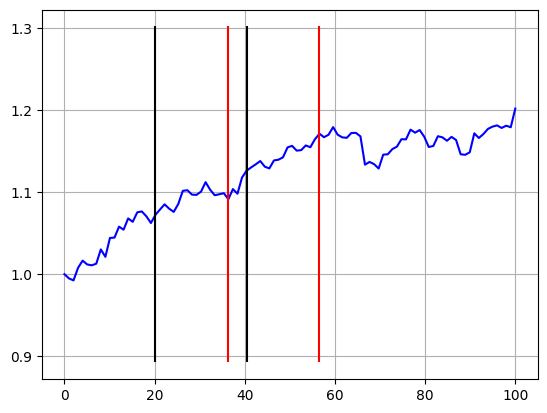

In [21]:
root_dir = "../data/data_dump"
stock_data = StockDataset(root_dir, seq_len=data_seq_len, num_days=num_days)

stock_nr = 3
stock_names = [name.split(".")[0] for name in stock_data.files]
print(f"Stock names: {stock_names}")

num_stocks = len(stock_data.files)
print(f"num stocks: {num_stocks}")
print()

abs_data = stock_data.recons_absol()
x = torch.linspace(0, len(abs_data[stock_nr,-1,:]), len(abs_data[stock_nr,-1,:]))
y = torch.mean(abs_data[:,0,:], dim=0)

val_idx = int(train_ratio*len(x))
test_idx = int((train_ratio + val_ratio)*len(x))

val_cut = x[val_idx]
test_cut = x[test_idx]

train_data = y[:val_idx]
val_data = y[val_idx:test_idx]
test_data = y[test_idx:]

for arr, text in zip([train_data, val_data, test_data], ["Train     ", "Validation", "Test      "]):
    interval_return = arr[-1] / arr[0] -1
    print(f"Interval return {text}: {interval_return:.2%}")

print()
for arr, text in zip([train_data, val_data, test_data], ["Train     ", "Validation", "Test      "]):
    buy_and_hold = arr[-1] / arr[seq_len] -1
    print(f"Trainig window adjusted return {text}: {buy_and_hold:.2%}")
    
plt.plot(x, y, color="blue")
plt.grid()
plt.vlines([val_cut, test_cut], torch.min(y) - 0.1, torch.max(y) + 0.1, color="black") # train/val/test split
plt.vlines([val_cut + seq_len, test_cut + seq_len], torch.min(y) - 0.1, torch.max(y) + 0.1, color="red") # window adjusted train/val/test split
plt.show()

In [22]:
data = stock_data.data # Pass OHLC

# [open, close, high, low, c/o, h/o, l/o, high - low, close-open, volume]

value_size = data.shape[1]
in_size = len(stock_data.files) # number of stocks

print(f"Stock dimension: {stock_data.data.shape}")
print(f"Value size: {value_size}")

Stock dimension: torch.Size([22, 15, 100])
Value size: 15


In [23]:
###############
#### Data #####
###############
train, val, test = split_time_series(data, train_ratio=train_ratio, val_ratio=val_ratio)
print(f"Shapes: train={train.shape} val={val.shape} test={test.shape}")

train_ds = TimeSeriesDataset(train, seq_len, max_deviation)
val_ds = TimeSeriesDataset(val, seq_len, max_deviation)
test_ds = TimeSeriesDataset(test, seq_len, max_deviation)
#print(f"Shapes: train={train.shape} val={val.shape} test={test.shape}")

# (Batch, in_size, seq_len)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

Shapes: train=torch.Size([22, 15, 20]) val=torch.Size([22, 15, 20]) test=torch.Size([22, 15, 60])


/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_75222/2736515995.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)


In [24]:
model = Transformer(d_model, in_size, value_size, seq_len, bin_centers,
                    num_heads, lstm_layers, num_transformer_blocks, dropout, kernel_size, sigma).to(device)

params = [p for n, p in model.named_parameters()]

optimizer = ArbitraryMomentumSGD(
    [
        {"params": params, "lr": lr_max},          # default LR
    ],
    momentum_schedule=lambda step: static_momentum
        + periodic_momentum * torch.cos(
            2 * torch.pi * torch.tensor(step) / torch.tensor(momentum_cycle)
        ),
    weight_decay=weight_decay
)

scheduler = get_warmup_cosine_scheduler(
    optimizer, warmup_steps=warmup_steps, plateau_steps=plateau_steps, total_steps=total_steps, lr_max=lr_max
)

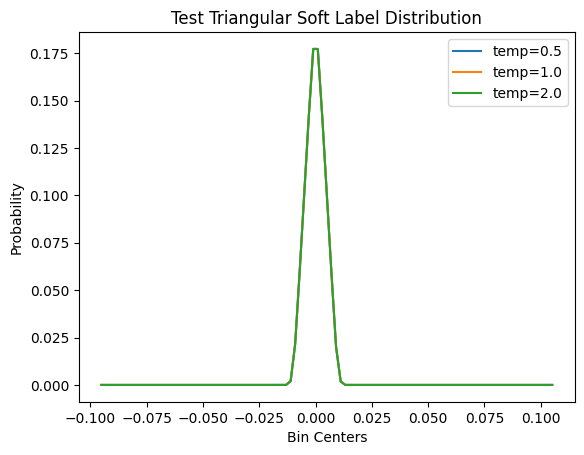

/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_75222/403079798.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


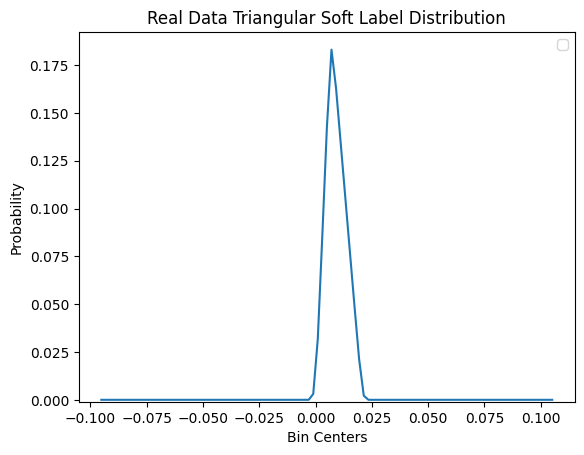

1.0


In [25]:
test_bin_centers = bin_centers.clone()  # coarse bins for clarity
co = torch.tensor([[0.0]])
lo = torch.tensor([[-0.01]])
hi = torch.tensor([[0.01]])

for temp in [0.5, 1.0, 2.0]:
    probs = triangular_soft_label(co, lo, hi, test_bin_centers, kernel_size, sigma)
    plt.plot(test_bin_centers.numpy(), probs[0, 0].numpy(), label=f"temp={temp}")

plt.title("Test Triangular Soft Label Distribution")
plt.xlabel("Bin Centers")
plt.ylabel("Probability")
plt.legend()
plt.show()

for batch_x, batch_y in train_loader:
            
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    co = batch_y[:, :, 0] # [B, A]
    hi = batch_y[:, :, 1]
    lo = batch_y[:, :, 2]

    target_probs = triangular_soft_label(co, lo, hi, test_bin_centers, kernel_size, sigma)  # [B, A, bins]
    target_probs = target_probs.detach().cpu().numpy()

    single_asset = target_probs[0, 5, :] # [bins]
    plt.plot(test_bin_centers.numpy(), single_asset)
    plt.ylim(-0.001)

    plt.title("Real Data Triangular Soft Label Distribution")
    plt.xlabel("Bin Centers")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()

    print(np.sum(single_asset))

    break

In [26]:
##################
#### Training ####
##################

# Set some parameters for the calc_alloc_return function
train_cash_threshold = 0.0
train_temp = 0.005
train_min_prob = 0.5
allow_leverage=False

returns_buffer = []

# Train LSTM model
for train_step in range(total_steps):

    
        
    all_train_losses = []
    all_val_losses = []

    train_loss = 0
    
    # Training
    model.train()
    
    for batch_x, batch_y in train_loader:
            
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        B, A, V, T = batch_x.shape

        #if perm_counter % 5 == 0:
            # Generate a random permutation of assets
        #perm = torch.randperm(A, device=batch_x.device)
        
        # Apply same permutation to both tensors along dim=1
        #batch_x = batch_x[:, perm, :, :]
        #batch_y = batch_y[:, perm]

        # train stock predictor
        optimizer.zero_grad()
        
        pred_probs = model(batch_x) # [B, A, bins]

        co = batch_y[:, :, 0] # [B, A]
        hi = batch_y[:, :, 1]
        lo = batch_y[:, :, 2]

        target_probs = triangular_soft_label(co, lo, hi, bin_centers, kernel_size, sigma)  # [B, A, bins]
        
        loss = wasserstein_loss(pred_probs, target_probs)
        
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.5)
    
        optimizer.step()
        train_loss += loss

        #perm_counter += 1

    scheduler.step()
    avg_train_loss = train_loss / len(train_loader) / in_size

    # Validation
    val_loss = 0

    returns_buffer = []
    total_ret, sample_count = 0, 0
    
    for val_x, val_y in val_loader:
        val_x = val_x.to(device)
        val_y = val_y.to(device)

        model.eval()
        
        pred_probs = model(val_x) # [B, A, bins]

        co = val_y[:, :, 0] # [B, A]
        hi = val_y[:, :, 1]
        lo = val_y[:, :, 2]

        target_probs = triangular_soft_label(co, lo, hi, bin_centers, kernel_size, sigma)  # [B, A, bins]

        loss = wasserstein_loss(pred_probs, target_probs)
        
        val_loss += loss
        
        alloc, port_ret, single_returns, leverage = calc_alloc_return(
                            pred_probs, co, bin_centers,
                            cash_threshold=train_cash_threshold,
                            temp=train_temp,
                            apply_confidence_mask=False,
                            min_prob=train_min_prob,
                            allow_leverage=allow_leverage,
                            num_selec_asset=num_selec_asset
                        )
        
        returns_buffer.append(port_ret)  # accumulate tensors directly
        total_ret += port_ret.sum().item()
        sample_count += port_ret.shape[0]

    returns_tensor = torch.cat(returns_buffer, dim=0)  # shape [N], retains grad
    
    sharpe_ratio, max_drawdown, annualized_return, equity_curve = calc_performance_metrics(returns_tensor)
                        
    avg_val_loss = val_loss / len(val_loader) / in_size
            
    if (train_step % 1 == 0):
        
        group = optimizer.param_groups[0]
        step = group['step']
        momentum_schedule = group['momentum_schedule']
        current_momentum = momentum_schedule(step)

        print(f"<========== Training metrics ==========>")
        print(f"Step              : {train_step+1}/{total_steps}")
        print(f"LR in microns     : {scheduler.get_last_lr()[0]*10e6:.1f}")
        print(f"Current Momentum  : {current_momentum:.2f}")
        print()
        print(f"Train Loss        : {avg_train_loss:.4f}")
        print(f"Validation Loss   : {avg_val_loss:.4f}")
        #print(f"Std{pred_probs.std(dim=-1).mean():.4f})
        print(f"<========== Quick Validation set Performance ==========>")
        print(f"Final cumulative return: {equity_curve[-1] - 1:.2%}")
        print(f"Annualized return: {annualized_return:.2%}")
        print(f"Sharpe ratio: {sharpe_ratio:.2f}")
        print(f"Max drawdown: {max_drawdown:.2%}")
        print()

torch.save({'model_state_dict': model.state_dict()}, f"pre_trained.pth")

In [27]:
##############################
#### single step learning ####
##############################

cash_threshold = 0.01
temp = 0.05
min_prob = 0.60

allow_leverage = True

# Training Parameters
lr_single = 5e-5
weight_decay_single = 0.0
momentum_single = 0.99

sgd_opt = ArbitraryMomentumSGD(
    model.parameters(),
    lr=lr_single,
    momentum_schedule=lambda step: momentum_single + 0.0 * torch.tensor(step),
    weight_decay=weight_decay
)

returns_buffer = []
allocs_buffer = []
single_returns_buffer = []
leverage_returns_buffer = []
total_ret, sample_count = 0, 0

val_loss = 0

train_iters = 1
training_steps = 25

train, val, test = split_time_series(data, train_ratio=train_ratio, val_ratio=val_ratio)
data_set = test

# Use pretrained model and train for a few datapoints before evaluating each datapoint
for k in range(data_set.shape[-1] - training_steps - seq_len - 1):

    if (k % 2 == 1):
        
        print(f"<========== Training metrics ==========>")
        print(f"Step              : {k+1}/{data_set.shape[-1] - training_steps - seq_len - 1}")

    train_ds = TimeSeriesDataset(data_set[:, :, k: k + seq_len + training_steps + 1], seq_len, max_deviation)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
    
    # Reset to pre trained state for every iteration
    model = Transformer(d_model, in_size, value_size, seq_len, bin_centers, num_heads,
                        lstm_layers, num_transformer_blocks, dropout, kernel_size, sigma).to(device)
    
    #checkpoint = torch.load(f"pre_trained.pth")
    #model.load_state_dict(checkpoint["model_state_dict"])

    data_pair = 0
    for train_x, train_y in train_loader:

        train_x = train_x.to(device)
        train_y = train_y.to(device)

        for s in range(train_iters):

            #if s < train_iters -1:
                # Generate a random permutation of assets
                #perm = torch.randperm(A, device=batch_x.device)
                
                # Apply same permutation to both tensors along dim=1
                #train_x = train_x[:, perm, :, :]
                #train_y = train_y[:, perm]
            
            ###################
            ### First train ###
            ###################
            if data_pair < training_steps - 1:
                
                model.train()

                pred_probs = model(train_x) # [B, A, bins]

                co = train_y[:, :, 0] # [B, A]
                hi = train_y[:, :, 1]
                lo = train_y[:, :, 2]
        
                target_probs = triangular_soft_label(co, lo, hi, bin_centers, kernel_size, sigma)  # [B, A, bins]
                loss = wasserstein_loss(pred_probs, target_probs)
        
                # train stock predictor
                sgd_opt.zero_grad()
            
                loss.backward()
                sgd_opt.step()

        #####################
        ### Then evaluate ###
        #####################
        if data_pair == training_steps - 1:
                    
            model.eval()

            pred_probs = model(train_x) # [B, A, bins]

            co = train_y[:, :, 0] # [B, A]
            hi = train_y[:, :, 1]
            lo = train_y[:, :, 2]
    
            target_probs = triangular_soft_label(co, lo, hi, bin_centers, kernel_size, sigma)  # [B, A, bins]
            loss = wasserstein_loss(pred_probs, target_probs)

            val_loss += loss.item()
                    
            alloc, port_ret, single_returns, leverage = calc_alloc_return(
                                                        pred_probs, co, bin_centers,
                                                        cash_threshold=cash_threshold,
                                                        temp=temp,
                                                        apply_confidence_mask=True,
                                                        min_prob=min_prob,
                                                        allow_leverage=allow_leverage,
                                                        num_selec_asset=num_selec_asset
                                                   )
        
            single_returns_buffer.append(single_returns)
            leverage_returns_buffer.append(leverage)
            returns_buffer.append(port_ret)  # accumulate tensors directly
            allocs_buffer.append(alloc)
            total_ret += port_ret.sum().item()
            sample_count += port_ret.shape[0]
        
        data_pair +=1

avg_train_loss = val_loss / (data_set.shape[-1] - training_steps - seq_len - 1) / in_size

returns_tensor = torch.cat(returns_buffer, dim=0)  # shape [N], retains grad
sharpe_ratio, max_drawdown, annualized_return, equity_curve = calc_performance_metrics(returns_tensor)

print(f"<========== Online Learaning Performance ==========>")
print(f"Loss                   : {avg_train_loss:.4f}")
print(f"Final cumulative return: {equity_curve[-1] - 1:.2%}")
print(f"Annualized return      : {annualized_return:.2%}")
print(f"Sharpe ratio           : {sharpe_ratio:.2f}")
print(f"Max drawdown           : {max_drawdown:.2%}")

/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_75222/2736515995.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)


<========== Training metrics ==========>
Step              : 2/18
<========== Training metrics ==========>
Step              : 4/18
<========== Training metrics ==========>
Step              : 6/18
<========== Training metrics ==========>
Step              : 8/18
<========== Training metrics ==========>
Step              : 10/18
<========== Training metrics ==========>
Step              : 12/18
<========== Training metrics ==========>
Step              : 14/18
<========== Training metrics ==========>
Step              : 16/18
<========== Training metrics ==========>
Step              : 18/18
<========== Online Learaning Performance ==========>
Loss                   : 1.0607
Final cumulative return: 0.03%
Annualized return      : 0.35%
Sharpe ratio           : 0.15
Max drawdown           : -3.80%


In [28]:
print(f"\n<========== Final Test Performance ==========>")
print(f"Final cumulative return: {equity_curve[-1] - 1:.2%}")
print(f"Buy and Hold return: {buy_and_hold:.2%}")
print(f"Annualized return: {annualized_return:.2%}")
print(f"Sharpe ratio: {sharpe_ratio:.2f}")
print(f"Max drawdown: {max_drawdown:.2%}")

print(f"\n<========== S&P 500 Performance ==========>")
print(f"Final cumulative return: {0.285 * len(equity_curve) / 390:.2%}")
print(f"Annualized return: 18.9%")
print(f"Sharpe ratio: 1.40")
print(f"Max drawdown: -8%")

print()
print(f"Number of samples: {len(equity_curve)}")

print(f"\n<========== Bootstrap results ==========>")
results = compute_bootstrap_metrics(returns_tensor, n_bootstrap=1000, ci=0.95)
for name, (mean_val, low, high) in results.items():
    print(f"{name.replace('_', ' ').title()}: {mean_val*100:.2f}% "
          f"[{low*100:.2f}%, {high*100:.2f}%]")


<========== Final Test Performance ==========>
Final cumulative return: 0.03%
Buy and Hold return: 2.62%
Annualized return: 0.35%
Sharpe ratio: 0.15
Max drawdown: -3.80%

<========== S&P 500 Performance ==========>
Final cumulative return: 1.32%
Annualized return: 18.9%
Sharpe ratio: 1.40
Max drawdown: -8%

Number of samples: 18

<========== Bootstrap results ==========>
Daily Return: 0.02% [-0.74%, 0.91%]
Cumulative Return: 0.37% [-12.69%, 17.07%]
Annualized Return: 86.04% [-85.04%, 807.97%]
Sharpe Ratio: -62.14% [-842.96%, 605.76%]
Max Drawdown: -4.87% [-12.82%, 0.00%]


/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_75222/998098917.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


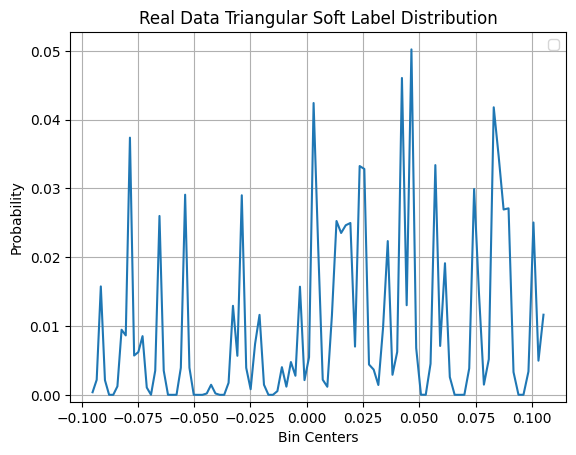

1.0000001


In [29]:
model.eval()

for batch_x, batch_y in test_loader:
            
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    co = batch_y[:, :, 0] # [B, A]
    hi = batch_y[:, :, 1]
    lo = batch_y[:, :, 2]

    pred_probs = model(train_x) # [B, A, bins]

    target_probs = triangular_soft_label(co, lo, hi, test_bin_centers, kernel_size, sigma)  # [B, A, bins]
    target_probs = target_probs.detach().cpu().numpy()

    single_asset = pred_probs[0, 3, :].detach().cpu().numpy() # [bins]
    plt.plot(test_bin_centers.numpy(), single_asset)
    plt.ylim(-0.001)

    plt.title("Real Data Triangular Soft Label Distribution")
    plt.xlabel("Bin Centers")
    plt.ylabel("Probability")
    plt.grid()
    plt.legend()
    plt.show()

    print(np.sum(single_asset))

    break

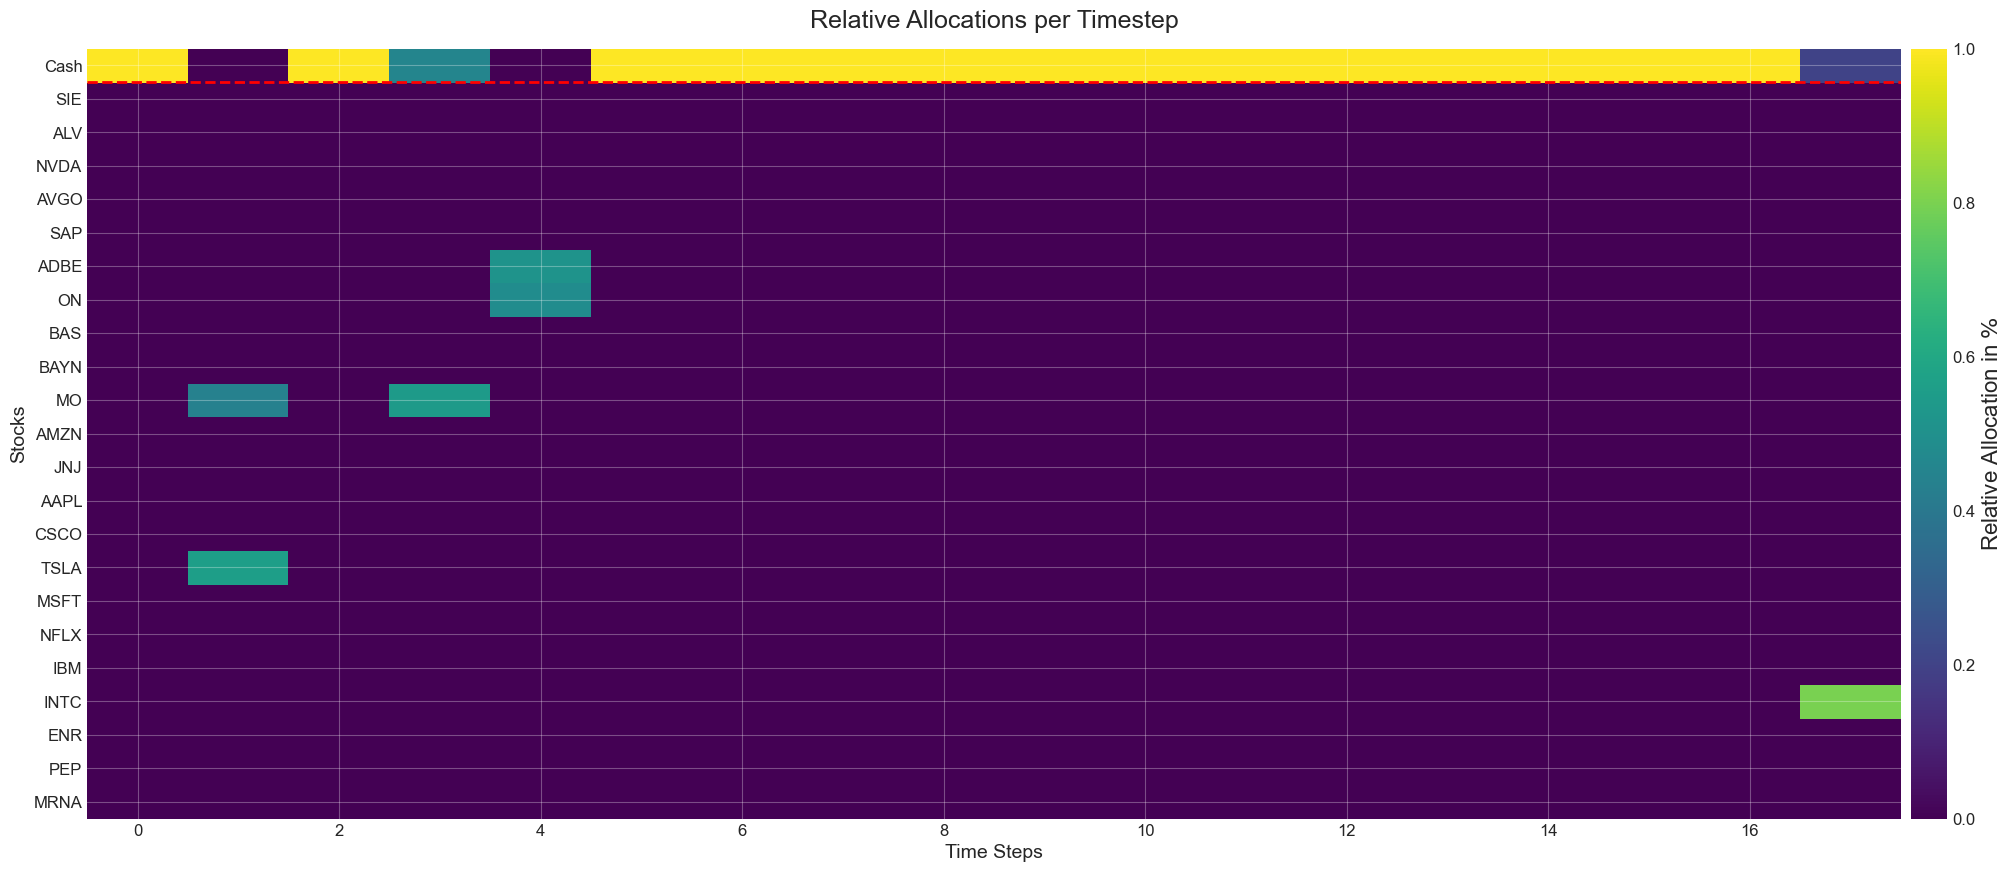

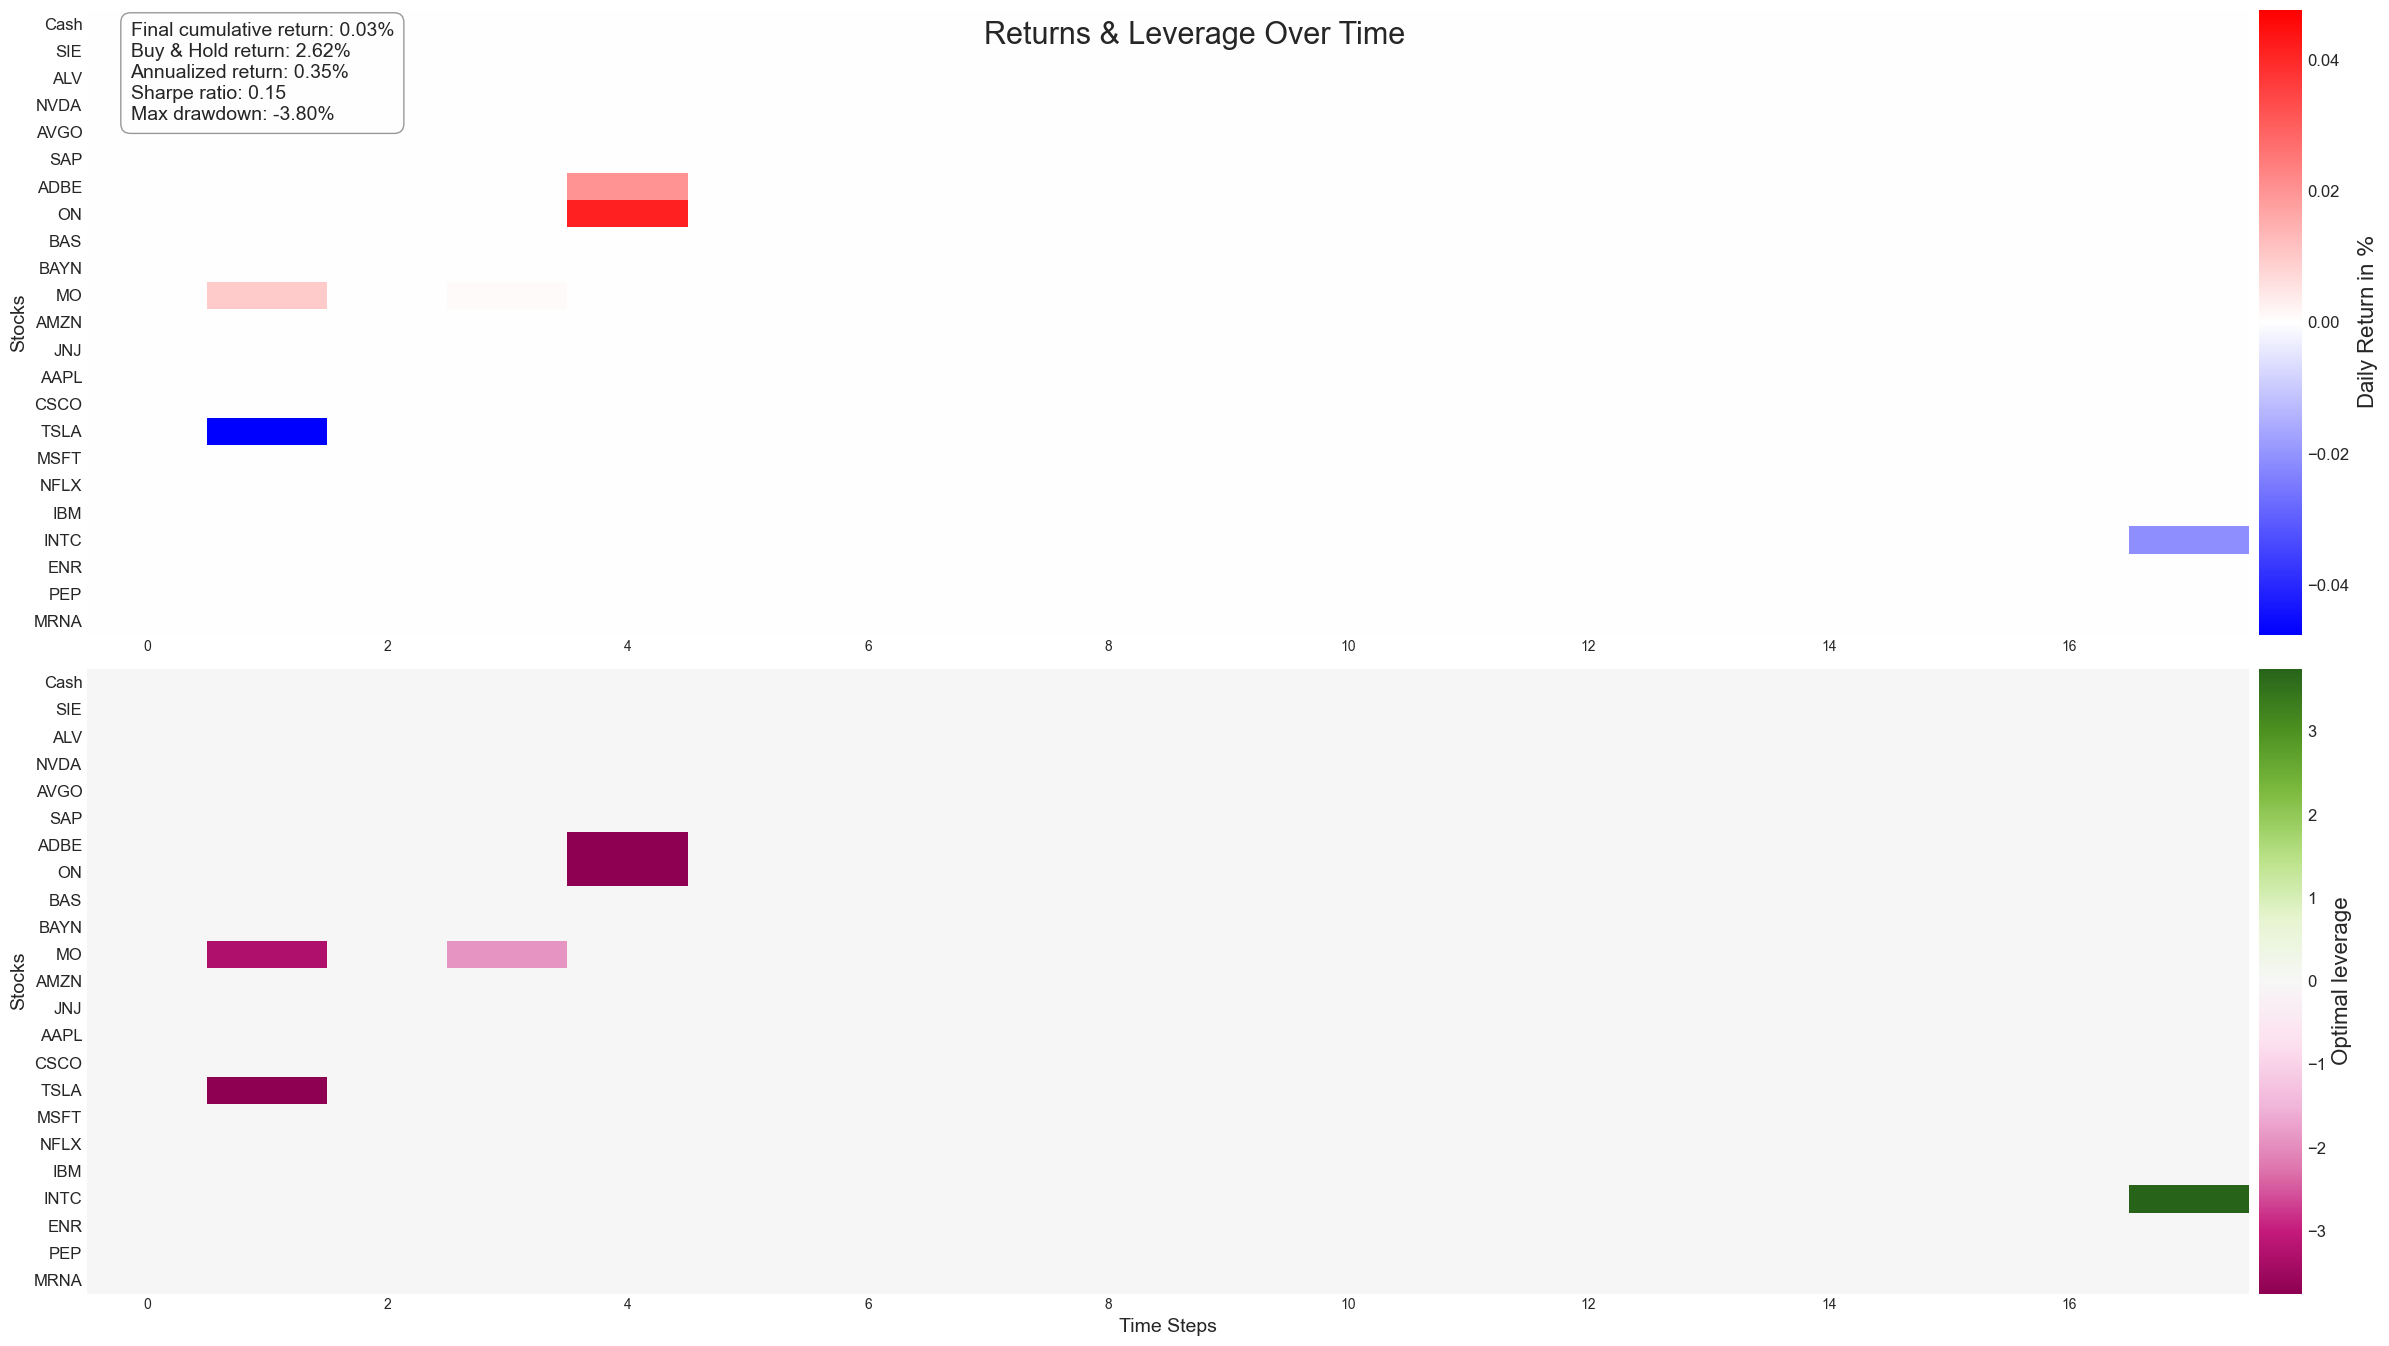

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use("seaborn-v0_8-darkgrid")  # Fancy style

# Get stock names for plotting labels
stock_names = [filename.split(".")[0] for filename in stock_data.files]
# Add cash threshold to labels
stock_names.append("Cash")

# Convert tensors to numpy
allocs_tensor = torch.cat(allocs_buffer, dim=0).detach().cpu().numpy()
single_returns_tensor = torch.cat(single_returns_buffer, dim=0).detach().cpu().numpy()
leverage_returns_tensor = torch.cat(leverage_returns_buffer, dim=0).detach().cpu().numpy()

#################
## Allocations ##
#################
alloc_fig, alloc_ax = plt.subplots(figsize=(24, 10))  # Manageable size

divider = make_axes_locatable(alloc_ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

image = alloc_ax.imshow(allocs_tensor.T, origin="lower", vmin=0, aspect="auto", cmap="viridis")

cb = alloc_fig.colorbar(image, cax=cax)
cb.set_label(r"Relative Allocation in $\%$", fontsize=16)
cb.ax.tick_params(labelsize=12)

alloc_ax.set_yticks(range(len(stock_names)))
alloc_ax.set_yticklabels(stock_names, fontsize=12)
alloc_ax.tick_params(axis="x", labelsize=12)

alloc_ax.set_xlabel("Time Steps", fontsize=14)
alloc_ax.set_ylabel("Stocks", fontsize=14)
alloc_ax.set_title("Relative Allocations per Timestep", fontsize=18, pad=15)

alloc_ax.grid(alpha=0.3, color="white")

# Visually separate cash from actual stock allocations
cash_idx = len(stock_names) - 1  # last row
alloc_ax.axhline(cash_idx - 0.5, color="red", linewidth=2, linestyle="--")

#################
#### Returns ####
#################
fig, (ret_ax, lev_ax) = plt.subplots(
    nrows=2, figsize=(24, 14), gridspec_kw={"height_ratios": [1, 1]}
)

# ---- Single Returns ----
ret_divider = make_axes_locatable(ret_ax)
ret_cax = ret_divider.append_axes("right", size="2%", pad=0.1)

max_value = np.max(np.abs(single_returns_tensor))
image = ret_ax.imshow(
    single_returns_tensor.T, origin="lower",
    vmin=-max_value, vmax=max_value, aspect="auto", cmap="bwr"
)

ret_cb = fig.colorbar(image, cax=ret_cax)
ret_cb.set_label(r"Daily Return in $\%$", fontsize=16)
ret_cb.ax.tick_params(labelsize=12)

ret_ax.set_yticks(range(len(stock_names)))
ret_ax.set_yticklabels(stock_names, fontsize=12)
ret_ax.set_ylabel("Stocks", fontsize=14)
#ret_ax.set_title("Single Stock Returns", fontsize=18, pad=15)
ret_ax.grid(alpha=0.0, color="black")

# Add raw numbers to the plot
metrics_text = (
    f"Final cumulative return: {equity_curve[-1] - 1:.2%}\n"
    f"Buy & Hold return: {buy_and_hold:.2%}\n"
    f"Annualized return: {annualized_return:.2%}\n"
    f"Sharpe ratio: {sharpe_ratio:.2f}\n"
    f"Max drawdown: {max_drawdown:.2%}"
)

# Place in top left of ret_ax
ret_ax.text(
    0.02, 0.98, metrics_text,
    transform=ret_ax.transAxes,
    fontsize=14, va="top", ha="left",
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="gray", boxstyle="round,pad=0.5")
)

# ---- Leverage Returns ----
lev_divider = make_axes_locatable(lev_ax)
lev_cax = lev_divider.append_axes("right", size="2%", pad=0.1)

leverage_returns_tensor = np.where(allocs_tensor > 0.0, leverage_returns_tensor, 0.0)
max_leverage = np.max(np.abs(leverage_returns_tensor))
leverage_image = lev_ax.imshow(
    leverage_returns_tensor.T, origin="lower",
    vmin=-max_leverage, vmax=max_leverage, aspect="auto", cmap="PiYG"
)

lev_cb = fig.colorbar(leverage_image, cax=lev_cax)
lev_cb.set_label("Optimal leverage", fontsize=16)
lev_cb.ax.tick_params(labelsize=12)

lev_ax.set_yticks(range(len(stock_names)))
lev_ax.set_yticklabels(stock_names, fontsize=12)
lev_ax.set_xlabel("Time Steps", fontsize=14)
lev_ax.set_ylabel("Stocks", fontsize=14)
#lev_ax.set_title("Leverage per Timestep", fontsize=18, pad=15)
lev_ax.grid(alpha=0.0, color="black")

fig.suptitle("Returns & Leverage Over Time", fontsize=22, y=0.95)

plt.tight_layout()

# Save allocation figure
#alloc_fig.savefig("../images/allocations.png", dpi=300, bbox_inches="tight")

# Save returns/leverage figure
#fig.savefig("../images/returns_leverage.png", dpi=300, bbox_inches="tight")

plt.show()